<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Подключение-библиотек" data-toc-modified-id="Подключение-библиотек-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Подключение библиотек</a></span></li></ul></li><li><span><a href="#Прогнозирование-ряда-со-сложной-сезонностью" data-toc-modified-id="Прогнозирование-ряда-со-сложной-сезонностью-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Прогнозирование ряда со сложной сезонностью</a></span><ul class="toc-item"><li><span><a href="#Вспомогательные-функции" data-toc-modified-id="Вспомогательные-функции-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вспомогательные функции</a></span></li><li><span><a href="#Загрузка-данных" data-toc-modified-id="Загрузка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузка данных</a></span></li></ul></li></ul></div>

## Подключение библиотек

In [1]:
from os import path
import calendar

import pandas as pd
import numpy as np

import warnings
from scipy import stats
import statsmodels.api as sm

%pylab inline
from itertools import product

Populating the interactive namespace from numpy and matplotlib


In [2]:
# https://habr.com/ru/post/276725/
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

# Прогнозирование ряда со сложной сезонностью

## Вспомогательные функции

In [3]:
def get_data_file_name(year, month):
    return "{}-{:02d}.csv".format(year, month)

def get_bin_ind(x, xmin, xmax, bins):
    return ((x - xmin) / ((xmax - xmin)/bins)).values.astype(int)

def get_bin(x, y, xmin, xmax, ymin, ymax, xbins, ybins):
    return get_bin_ind(x, xmin, xmax, xbins)*xbins + get_bin_ind(y, ymin, ymax, ybins)

def read_data(ym_list):
    for y, m in ym_list:
        data_file = path.join('data', get_data_file_name(y, m))
        d = pd.read_csv(data_file)
        if "vendor_id" in d.columns:
            d.rename(columns={"vendor_id": "VendorID"}, inplace=True)
        if "pickup_datetime" in d.columns:
            d.rename(columns={"pickup_datetime": "tpep_pickup_datetime"}, inplace=True)
        if " pickup_datetime" in d.columns:
            d.rename(columns={" pickup_datetime": "tpep_pickup_datetime"}, inplace=True)
        if "dropoff_datetime" in d.columns:
            d.rename(columns={"dropoff_datetime": "tpep_dropoff_datetime"}, inplace=True)
        if " dropoff_datetime" in d.columns:
            d.rename(columns={" dropoff_datetime": "tpep_dropoff_datetime"}, inplace=True)
        if " passenger_count" in d.columns:
            d.rename(columns={" passenger_count": "passenger_count"}, inplace=True)
        if " trip_distance" in d.columns:
            d.rename(columns={" trip_distance": "trip_distance"}, inplace=True)
        if " pickup_longitude" in d.columns:
            d.rename(columns={" pickup_longitude": "pickup_longitude"}, inplace=True)
        if " pickup_latitude" in d.columns:
            d.rename(columns={" pickup_latitude": "pickup_latitude"}, inplace=True)            
        yield d
        
def read_columns(ym_list):
    for y, m in ym_list:
        data_file = path.join('data', get_data_file_name(y, m))
        d = pd.read_csv(data_file, nrows=1).columns
        yield d

In [4]:
def clear_data(d):
    d["tpep_pickup_datetime"] = pd.to_datetime(d.tpep_pickup_datetime)
    d["tpep_dropoff_datetime"] = pd.to_datetime(d.tpep_dropoff_datetime)
    
    duration = d.tpep_dropoff_datetime - d.tpep_pickup_datetime
    d = d[duration > datetime.timedelta(seconds=0)]
    d = d[d.passenger_count!=0]
    d = d[d.trip_distance!=0]
    d["tpep_pickup_datetime"] = d.tpep_pickup_datetime.dt.floor('H')
    inbound = ((d.pickup_longitude >= x0) & (d.pickup_longitude <= x1) & 
         (d.pickup_latitude >= y0) & (d.pickup_latitude <= y1))
    d = d[inbound]
    return d

In [5]:
def add_region(d):
    region = get_bin(d.pickup_longitude, d.pickup_latitude, xmin, xmax, ymin, ymax, 50, 50) + 1
    d['region'] = region
    return d

In [6]:
def agg_data(d, year, month):
    last_day = calendar.monthrange(year, month)[1]
    counts = d.groupby(['region', 'tpep_pickup_datetime']).count()['VendorID']
    counts.name = 'count'
    counts_u = counts.unstack(level=0, fill_value=0)
    new_index = pd.date_range(datetime.datetime(year=year, month=month, day=1),
                              datetime.datetime(year=year, month=month, day=last_day, hour=23), freq='H')
    new_columns = range(1,2501)
    counts_full = counts_u.reindex(index=new_index, columns=new_columns).fillna(0).astype(int)
    return counts_full

## Загрузка данных

Посмотрим на названия столбцов

In [7]:
ym_list = list(product(range(2013,2017), range(1,13)))[:-6]
columns = []
for d in log_progress(read_columns(ym_list), every=1, size=42):
    columns.append(d)

In [8]:
cols = pd.DataFrame(columns)

In [9]:
# cols
# Тут я посмотрел, что некоторые столбцы по-разному называются и учел это при загрузке данных в read_data

In [10]:
regions = pd.read_csv('regions.csv', ';')
xmin = regions.west.min()
xmax = regions.east.max()
ymin = regions.south.min()
ymax = regions.north.max()

In [11]:
ym_list = list(product(range(2013,2017), range(1,13)))[:-6]
counts = []
x0 ,x1, y0, y1 = -74.25559, -73.70000999999999, 40.49612, 40.91553
for d in log_progress(read_data(ym_list), every=1, size=42):
    d = clear_data(d)
    month = d.tpep_dropoff_datetime.dt.month.iloc[0]
    year = d.tpep_dropoff_datetime.dt.year.iloc[0]
    d = add_region(d)
    counts_full = agg_data(d, year, month)
    counts.append(counts_full)
    del d

E:\Users\alex\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3331: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
full_counts = pd.concat(counts)
full_counts.to_pickle("full_counts.pkl")

In [13]:
# full_counts = pd.read_pickle("full_counts.pkl")

In [15]:
fc = pd.read_pickle("full_counts.pkl")

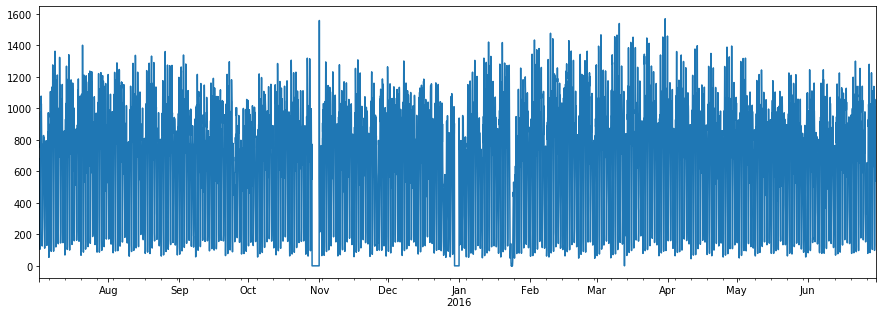

In [28]:
pylab.figure(figsize=(15,5))
fc[1231].iloc[-365*24:].plot()